In [1]:
import tensorflow as tf
# import tensorflow_addons as tfa
import svmbir
import numpy as np
import os
import matplotlib.pyplot as plt
from best.sim import create_strain_tensor, generate_strain_sino
import best.utils as b_utils
# import vtk
# from vtk.util.numpy_support import numpy_to_vtk


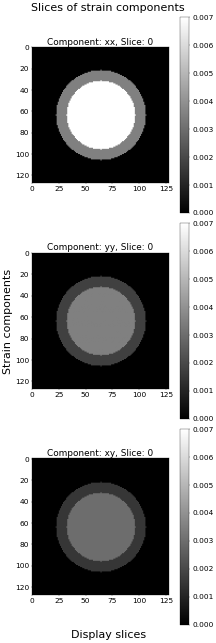

In [2]:
detector_rows = 1
detector_columns = 128
sample_type = 'ConCylinder'  # Choose from 'Cylinder', 'ConCylinder', 'Gaussian', and 'StVenant'

# Projection parameters
num_angles = 180
vox_xyz = 28

# Display parameters
display_comps = [0, 1, 3]
display_slices = [0]
detector_row_sinogram = 0

# Path to save generated projection data
proj_data_path = '../demo/demo_data'

# Create the directories if they don't exist
os.makedirs(proj_data_path, exist_ok=True)

# Generate rotation angles
angles = np.linspace(0, 180, num_angles)

# Generate strain tensor
strain_tensor = create_strain_tensor(detector_rows, detector_columns, sample_type)

# Save strain tensor
filename = os.path.join(proj_data_path, 'strain_tensor.npy')
np.save(filename, strain_tensor)

# Show slices for the different strain components
b_utils.plot_strain_tensor(strain_tensor, display_comps, display_slices, vmax=np.max(strain_tensor),
                           vmin=np.min(strain_tensor))

In [12]:
class TomoRadon:

    def __init__(self, rec, ang):
        self.rec = rec
        self.ang = ang
    def rotate_images(image, angles_degrees):
    # """
    # Rotate an image by each angle in a list of angles.

    # Args:
    # image: A 3D tensor of shape [height, width, channels].
    # angles_degrees: A list of angles in degrees to rotate the image.

    # Returns:
    # A list of tensors, each representing the image rotated by one of the specified angles.
    # """
       rotated_images = []
       for angle in angles_degrees:
           radians = tf.constant(angle * tf.pi / 180, dtype=tf.float32)
           rotated_image = tf.image.rot90(image, k=angle//90)  # Simple rotation by 90, 180, 270 degrees
           rotated_images.append(rotated_image)
    
       return rotated_images

    def compute(self):
        nang = self.ang.shape[0]
        img = tf.transpose(self.rec, [3, 1, 2, 0])
        img = tf.tile(img, [nang, 1, 1, 1])
        img = tfa.image.rotate(img, -self.ang, interpolation='bilinear')
        sino = tf.reduce_mean(img, 1, name=None)
        sino = tf.image.per_image_standardization(sino)
        sino = tf.transpose(sino, [2, 0, 1])
        sino = tf.reshape(sino, [sino.shape[0], sino.shape[1], sino.shape[2], 1])
        return sino

(180, 1, 128)


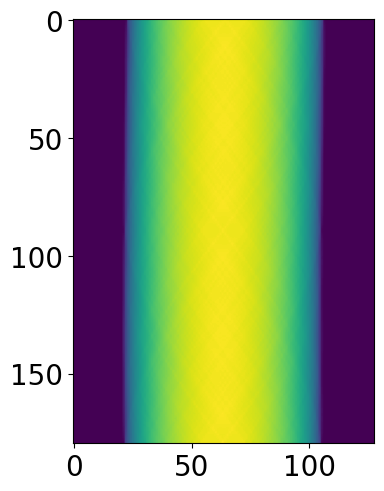

(6, 128, 128)
(180, 6, 128)
(180, 1, 128)


NameError: name 'norm_const' is not defined

In [3]:
num_ang = len(angles)
detector_rows = strain_tensor.shape[1]
detector_columns = strain_tensor.shape[2]

    # Out of plane rotation
psi = 90

    # Convert from degree to radian
angles = angles * np.pi / 180
psi = psi * np.pi / 180

    # Generate volume mask
vol_mask = np.zeros((detector_rows, detector_columns, detector_columns))
vol_mask = 1 * (np.sum(np.absolute(strain_tensor), axis=0) > 0.0)

    # Obtain thickness by projecting volume mask
thickness = svmbir.project(vol_mask, angles, detector_columns, delta_channel=vox_xyz, verbose=0)
print(thickness.shape)
plt.imshow(thickness[:,0,:])
plt.show()
    # Project each component of strain at all angles
strain_tensor = np.reshape(strain_tensor, (-1, detector_columns, detector_columns))
print(strain_tensor.shape)
proj_strain_comp = svmbir.project(strain_tensor, angles, detector_columns, delta_channel=vox_xyz, verbose=0)
print(proj_strain_comp.shape)
proj_strain_comp = np.reshape(proj_strain_comp, (num_ang, -1, detector_rows, detector_columns))

    # Sum the 6 components by weighting them by the appropriate cosine, sine values
proj_strain_comp = np.moveaxis(proj_strain_comp, 0, -1)

proj_strain_ws = proj_strain_comp[0] * (np.cos(angles) ** 2) * (np.sin(psi) ** 2) + \
                     proj_strain_comp[1] * (np.sin(angles) ** 2) * (np.sin(psi) ** 2) + \
                     proj_strain_comp[2] * (np.cos(psi) ** 2) + \
                     proj_strain_comp[3] * (np.sin(2 * angles)) * (np.sin(psi) ** 2) + \
                     proj_strain_comp[4] * (np.sin(angles)) * (np.sin(2 * psi)) + \
                     proj_strain_comp[5] * (np.cos(angles)) * (np.sin(2 * psi))

proj_strain_ws = np.moveaxis(proj_strain_ws, -1, 0)

print(proj_strain_ws.shape)
    # Divide the weighted sums by the thickness values to obtain the strain sinogram
strain_sino = np.divide(proj_strain_ws, thickness, out=np.zeros_like(proj_strain_ws), where=thickness != 0)

    # Normalize the strain sinogram using the normalizing matrix
strain_sino *= norm_const



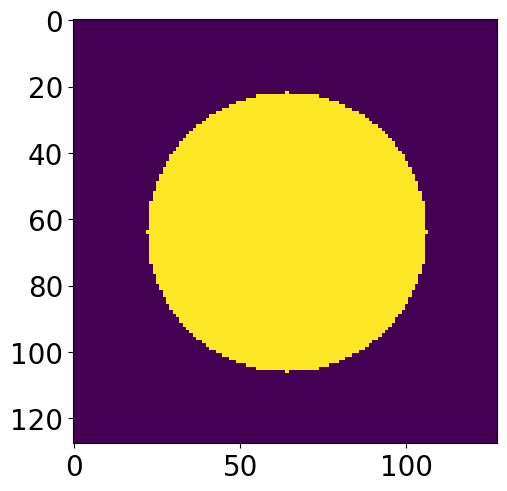

In [8]:
plt.imshow(vol_mask[0,:,:])
plt.show()

In [10]:
print(vol_mask.min())

0


In [ ]:
import tifffile
tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/thickness_tf.tiff', thickness.numpy())

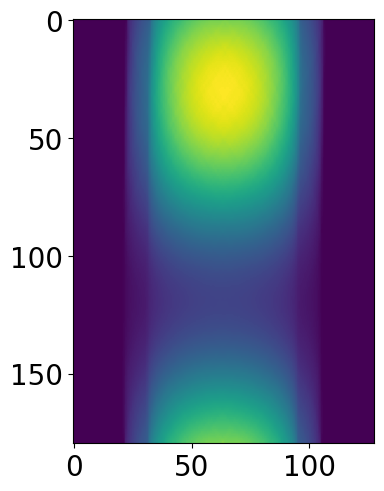

In [7]:
plt.imshow(proj_strain_ws[:,0,:])
plt.show()

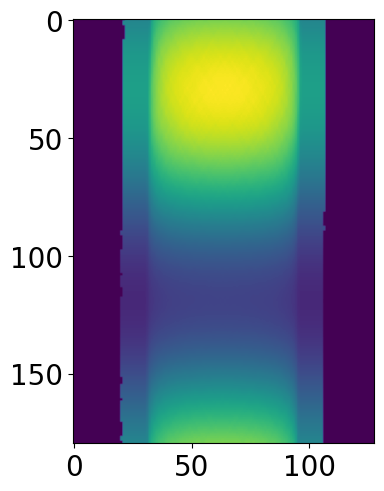

In [5]:
plt.imshow(strain_sino[:,0,:])
plt.show()

In [4]:
(np.cos(angles) ** 2) * (np.sin(psi) ** 2)

array([1.00000000e+00, 9.99692001e-01, 9.98768384e-01, 9.97230287e-01,
       9.95079604e-01, 9.92318985e-01, 9.88951832e-01, 9.84982292e-01,
       9.80415256e-01, 9.75256351e-01, 9.69511932e-01, 9.63189077e-01,
       9.56295575e-01, 9.48839919e-01, 9.40831294e-01, 9.32279567e-01,
       9.23195274e-01, 9.13589606e-01, 9.03474397e-01, 8.92862110e-01,
       8.81765819e-01, 8.70199194e-01, 8.58176485e-01, 8.45712504e-01,
       8.32822607e-01, 8.19522675e-01, 8.05829092e-01, 7.91758728e-01,
       7.77328920e-01, 7.62557443e-01, 7.47462497e-01, 7.32062678e-01,
       7.16376959e-01, 7.00424665e-01, 6.84225448e-01, 6.67799267e-01,
       6.51166357e-01, 6.34347211e-01, 6.17362551e-01, 6.00233300e-01,
       5.82980562e-01, 5.65625592e-01, 5.48189772e-01, 5.30694582e-01,
       5.13161577e-01, 4.95612357e-01, 4.78068542e-01, 4.60551747e-01,
       4.43083552e-01, 4.25685478e-01, 4.08378959e-01, 3.91185316e-01,
       3.74125733e-01, 3.57221226e-01, 3.40492622e-01, 3.23960531e-01,
      

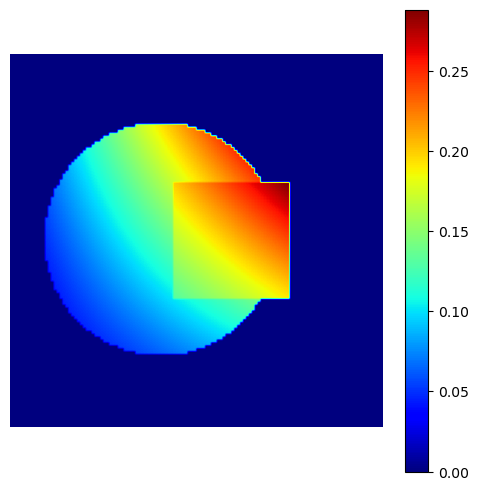

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

def create_circle_mask(dimensions, center, radius):
    """ Create a binary mask for a circle given dimensions, center, and radius. """
    Y, X = np.ogrid[:dimensions[0], :dimensions[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

def create_square_mask(dimensions, top_left, side_length):
    """ Create a binary mask for a square given dimensions, top-left corner, and side length. """
    mask = np.zeros(dimensions, dtype=bool)
    mask[top_left[1]:top_left[1]+side_length, top_left[0]:top_left[0]+side_length] = True
    return mask

def apply_gradient_to_shape(image, mask, start_intensity, end_intensity, horizontal_increase=True, vertical_increase=True):
    """ Apply a 2D gradient within the shape defined by the mask, with control over gradient direction. """
    indices = np.where(mask)
    # Create gradients with direction based on parameters
    vertical_range = np.linspace(start_intensity, end_intensity, mask.shape[0])
    if not vertical_increase:
        vertical_range = vertical_range[::-1]  # Reverse the vertical gradient
    horizontal_range = np.linspace(start_intensity, end_intensity, mask.shape[1])
    if not horizontal_increase:
        horizontal_range = horizontal_range[::-1]  # Reverse the horizontal gradient

    vertical_gradient = vertical_range[:, None]
    horizontal_gradient = horizontal_range[None, :]

    # Combine gradients to form a 2D gradient
    gradient = vertical_gradient * horizontal_gradient
    image[indices] = gradient[indices]


def create_image_with_gradients(width, height, radius, square_side, 
                                circle_center_ratio, square_center_ratio, 
                                horizontal_increase=True, 
                                vertical_increase=True):
    circle_center = (width * circle_center_ratio[0], height * circle_center_ratio[1])
    square_top_left = (int(width * square_center_ratio[0] - square_side / 2), 
                       int(height * square_center_ratio[1] - square_side / 2))

    image = np.zeros((height, width))

    # Create masks
    circle_mask = create_circle_mask((height, width), circle_center, radius)
    square_mask = create_square_mask((height, width), square_top_left, square_side)

    # Apply gradients within the masks
    apply_gradient_to_shape(image, circle_mask, 0.1, 1.0, horizontal_increase, vertical_increase)
    apply_gradient_to_shape(image, square_mask, 0.2, 1.0, horizontal_increase, vertical_increase)

    return image
# Image dimensions and shapes definitions
width=128
height=128


data = np.zeros((6, 1, height, width))
data[0, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5)) *0.5
data[1, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5))
data[2, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5))*0.1
data[3, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5)) *0.2
data[4, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5))*0.3
data[5, 0, :, :] = create_image_with_gradients(width, height, radius=40, square_side=40, 
                                circle_center_ratio=(0.4, 0.5), square_center_ratio=(0.6, 0.5))*0.8
# tifffile.imwrite('/nsls2/users/xyang4/data_tmp/tensor_tomography/strain_sim.tiff', data)
# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(data[0,0,:,:], cmap='jet', origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()

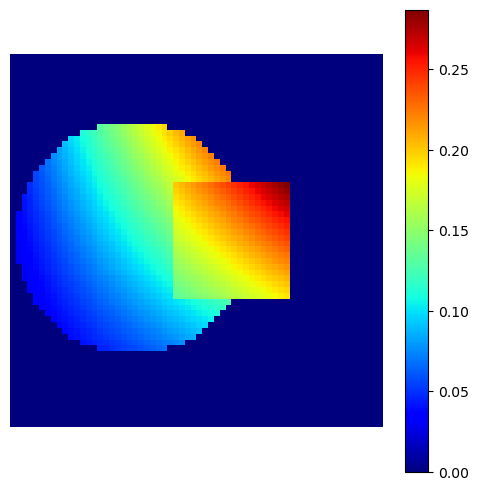

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

def create_circle_mask(dimensions, center, radius):
    """ Create a binary mask for a circle given dimensions, center, and radius. """
    Y, X = np.ogrid[:dimensions[0], :dimensions[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

def create_square_mask(dimensions, top_left, side_length):
    """ Create a binary mask for a square given dimensions, top-left corner, and side length. """
    mask = np.zeros(dimensions, dtype=bool)
    mask[top_left[1]:top_left[1]+side_length, top_left[0]:top_left[0]+side_length] = True
    return mask

def apply_gradient_to_shape(image, mask, start_intensity, end_intensity, horizontal_increase=True, vertical_increase=True):
    """ Apply a 2D gradient within the shape defined by the mask, with control over gradient direction. """
    indices = np.where(mask)
    # Create gradients with direction based on parameters
    vertical_range = np.linspace(start_intensity, end_intensity, mask.shape[0])
    if not vertical_increase:
        vertical_range = vertical_range[::-1]  # Reverse the vertical gradient
    horizontal_range = np.linspace(start_intensity, end_intensity, mask.shape[1])
    if not horizontal_increase:
        horizontal_range = horizontal_range[::-1]  # Reverse the horizontal gradient

    vertical_gradient = vertical_range[:, None]
    horizontal_gradient = horizontal_range[None, :]

    # Combine gradients to form a 2D gradient
    gradient = vertical_gradient * horizontal_gradient
    image[indices] = gradient[indices]


def create_image_with_gradients(width, height, radius, square_side, 
                                circle_center_ratio, square_center_ratio, 
                                horizontal_increase=True, 
                                vertical_increase=True):
    circle_center = (width * circle_center_ratio[0], height * circle_center_ratio[1])
    square_top_left = (int(width * square_center_ratio[0] - square_side / 2), 
                       int(height * square_center_ratio[1] - square_side / 2))

    image = np.zeros((height, width))

    # Create masks
    circle_mask = create_circle_mask((height, width), circle_center, radius)
    square_mask = create_square_mask((height, width), square_top_left, square_side)

    # Apply gradients within the masks
    apply_gradient_to_shape(image, circle_mask, 0.1, 1.0, horizontal_increase, vertical_increase)
    apply_gradient_to_shape(image, square_mask, 0.2, 1.0, horizontal_increase, vertical_increase)

    return image
# Image dimensions and shapes definitions
width=64
height=64

data = np.zeros((6, 64, height, width))
for i in range (64):
    circle_center_ratio = (0.32+i*0.002, 0.5)
    data_slice = create_image_with_gradients(width, height, radius=20, square_side=20, 
                                    circle_center_ratio=circle_center_ratio, square_center_ratio=(0.6, 0.5))
    data[0, i, :, :] = data_slice*0.5
    data[1, i, :, :] = data_slice
    data[2, i, :, :] = data_slice*0.1
    data[3, i, :, :] = data_slice *0.2
    data[4, i, :, :] = data_slice*0.3
    data[5, 0, :, :] = data_slice*0.8
tifffile.imwrite('/Users/xiaogangyang/data/tensor_tomography/strain_3d_sim.tiff', data)
# Plot the image
plt.figure(figsize=(6, 6))
plt.imshow(data[0,0,:,:], cmap='jet', origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()

In [19]:
# Set the grid size
n = 64

# Create a mesh grid

# Initialize the strain tensor components
# Strain tensor for each point is a 3x3 matrix
# We'll create a 5D array: (n, n, n, 3, 3) to store the tensor for the entire grid
strain_tensor = np.zeros((n, n, n, 3, 3))

# Define the components of the strain tensor
# Example: linear variation in x, y, z directions
strain_tensor[..., 0, 0] = data[0,:,:,:]  # xx component of strain
strain_tensor[..., 1, 1] = data[3,:,:,:]  # yy component of strain
strain_tensor[..., 2, 2] = data[5,:,:,:]  # zz component of strain

# Shear components, simple example using mixed terms
strain_tensor[..., 0, 1] = strain_tensor[..., 1, 0] = data[1,:,:,:]  # xy = yx component
strain_tensor[..., 0, 2] = strain_tensor[..., 2, 0] = data[2,:,:,:]  # xz = zx component
strain_tensor[..., 1, 2] = strain_tensor[..., 2, 1] = data[4,:,:,:]

In [5]:
import numpy as np

# Set the grid size
n = 10

# Create a mesh grid
x, y, z = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n)*2, np.linspace(0, 1, n)*3, indexing='ij')
print(x.shape)
# Initialize the strain tensor components
# Strain tensor for each point is a 3x3 matrix
# We'll create a 5D array: (n, n, n, 3, 3) to store the tensor for the entire grid
strain_tensor = np.zeros((n, n, n, 3, 3))

# Define the components of the strain tensor
# Example: linear variation in x, y, z directions
strain_tensor[..., 0, 0] = x  # xx component of strain
strain_tensor[..., 1, 1] = y  # yy component of strain
strain_tensor[..., 2, 2] = z  # zz component of strain

# Shear components, simple example using mixed terms
strain_tensor[..., 0, 1] = strain_tensor[..., 1, 0] = 0.5 * (x * y)  # xy = yx component
strain_tensor[..., 0, 2] = strain_tensor[..., 2, 0] = 0.5 * (x * z)  # xz = zx component
strain_tensor[..., 1, 2] = strain_tensor[..., 2, 1] = 0.5 * (y * z)  # yz = zy component


(10, 10, 10)


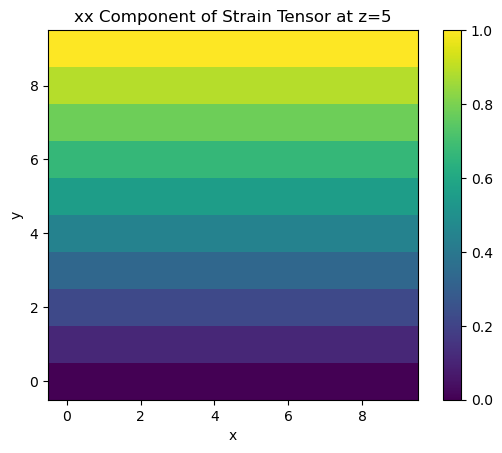

In [6]:
import matplotlib.pyplot as plt

# Choose a slice at halfway through the z-axis
slice_index = n // 2

# Plot the xx component of the strain tensor
plt.imshow(strain_tensor[:, :, slice_index, 0, 0], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('xx Component of Strain Tensor at z={}'.format(slice_index))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [20]:
import vtk
from vtkmodules.util.numpy_support import numpy_to_vtk
def save_tensor_field_as_vtk(tensor_data, filename):
    # Assuming tensor_data has the shape (Nx, Ny, Nz, 3, 3)
    Nx, Ny, Nz, _, _ = tensor_data.shape
    image_data = vtk.vtkImageData()
    image_data.SetDimensions(Nx, Ny, Nz)
    image_data.SetSpacing(1.0, 1.0, 1.0)
    flat_data = tensor_data.reshape(Nx * Ny * Nz, 9)
    vtk_data = numpy_to_vtk(num_array=flat_data, deep=True, array_type=vtk.VTK_FLOAT)
    vtk_data.SetNumberOfComponents(9)
    vtk_data.SetName("TensorData")
    image_data.GetPointData().SetTensors(vtk_data)
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(image_data)
    writer.Write()

save_tensor_field_as_vtk(strain_tensor, '/Users/xiaogangyang/data/tensor_tomography/tensor_field_sim.vti')